<a href="https://colab.research.google.com/github/rtsundby/blog/blob/master/Multi_omics_analysis_for_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring how to use multi-omics data to understand the cancer phenotype

This notebook was created for a live demo of the cptac python data API. You are welcome to play along at home. If you want to do that, enter the following URL in your browser: https://cutt.ly/ekMMht7

Your next step will be to save this notebook as a copy so that you can edit it. (File->Save a copy in Drive). Now you can run the code below and modify it if you want to explore you own questions.

In [ ]:
#server call to set up the VM, only necessary on Google Colabs
!pip install cptac

     |████████████████████████████████| 5.5MB 3.9MB/s 
     |████████████████████████████████| 122kB 49.3MB/s 
     |████████████████████████████████| 112kB 51.6MB/s 
     |████████████████████████████████| 245kB 39.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


# Part 1. setup up and intial exploration

In the code cell below are the three basic steps for setting up the package
1. Import the package, and the utility functions
2. Download data (this is only for the first use of the package)
3. Instantiate a variable for the cancer type of interest

If you have questions about the basic set up, please visit out tutorials at https://paynelab.github.io/cptac/

In [ ]:
import cptac
from cptac import utils
cptac.download("endometrial")
endo = cptac.Endometrial()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now we are ready to grab our data. The package gives you datasets in a tabular/matrix format called a *dataframe*. In this analysis, we are going to work with genomic, proteomic and clinical data. Often we will use a package function to merge multiple datatypes together into one table for convenience.

Our first step is find the most commonly mutated genes in endometrial cancer. 

In [ ]:
mutations = utils.get_frequently_mutated(endo)
sorted_mutations = mutations.sort_values(by=["Missense_Mut"], ascending=False)
sorted_mutations.head(15)

Name,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
157,PIK3CA,0.494737,0.484211,0.010526
166,PTEN,0.789474,0.463158,0.568421
116,KRAS,0.326316,0.326316,0.000000
55,CTNNB1,0.305263,0.305263,0.000000
158,PIK3R1,0.389474,0.231579,0.189474
134,MUC16,0.189474,0.178947,0.052632
149,OBSCN,0.157895,0.157895,0.042105
98,HUWE1,0.157895,0.157895,0.031579
96,HERC2,0.178947,0.157895,0.063158
87,FBXW7,0.189474,0.157895,0.042105


In the table above, you'll find our favorite gene, TP53, has a missense mutation in 15% of our population. That's the gene we're going to spend the rest of our time on today, but you could also explore your favorite cancer gene.

# Part 2. TP53 and tumor histology

TP53 is a popular cancer gene and is involved in DNA damage response (more [here](https://en.wikipedia.org/wiki/P53)). Today we'll look at the association between TP53 mutation status and the clinical characterization of tumors. To do this, let's join genomic data with clinical data. I'll select out only the histologic_type column, which is what tells us if the tumor is endometroid or serous. This clinical feature will be joined to the mutation data for TP53. A handy function in our package does all that for you. 

In [ ]:
tp53_clinical_df = endo.join_metadata_to_mutations(metadata_df_name='clinical', mutations_genes='TP53', metadata_cols=['Histologic_type'], tissue_type="tumor")
tp53_clinical_df.head(10)


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 74 samples for the TP53 gene (/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py, line 1)


Name,Histologic_type,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Patient_ID,,,,,
C3L-00006,Endometrioid,[Missense_Mutation],[p.R248W],Single_mutation,Tumor
C3L-00008,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
C3L-00032,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
C3L-00090,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
C3L-00098,Serous,[Missense_Mutation],[p.S241C],Single_mutation,Tumor
C3L-00136,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
C3L-00137,Endometrioid,[Missense_Mutation],[p.S127Y],Single_mutation,Tumor
C3L-00139,Serous,[Nonsense_Mutation],[p.R196*],Single_mutation,Tumor
C3L-00143,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor


I'm really interested in the overlap between serous tumors and TP53 mutation, and want to test whether there is a meaningful association between the two. This can be done with a Fisher's exact test. 

I am going to create a new column in my dataframe encoding the overlap. It can be thought of as the 2x2 matrix below

. | Serous | Endometroid
 --- | --- | ----
Mutant | cat-1 | cat-3
Wildtype | cat-2 | cat-4

In [ ]:
def mut_hist_overlap(row):
  if row['Histologic_type'] == 'Serous':
    if row['TP53_Mutation_Status'] == "Wildtype_Tumor":
      return 2
    else:
      return 1
  else:
    #not serous
    if row['TP53_Mutation_Status'] == "Wildtype_Tumor":
      return 4
    else:
      return 3
  return 0 #failure

#now apply the above function to make a new column
tp53_clinical_df['overlap_category'] = tp53_clinical_df.apply(mut_hist_overlap, axis=1)

We can print off the dataframe to inspect the new row and make sure it looks like what we want. Notice the new column called 'overlap_category' which classifies each tumor into one of our four categories.

In [ ]:
tp53_clinical_df.head(10)

Name,Histologic_type,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,overlap_category
Patient_ID,,,,,,
C3L-00006,Endometrioid,[Missense_Mutation],[p.R248W],Single_mutation,Tumor,3
C3L-00008,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,4
C3L-00032,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,4
C3L-00090,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,4
C3L-00098,Serous,[Missense_Mutation],[p.S241C],Single_mutation,Tumor,1
C3L-00136,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,4
C3L-00137,Endometrioid,[Missense_Mutation],[p.S127Y],Single_mutation,Tumor,3
C3L-00139,Serous,[Nonsense_Mutation],[p.R196*],Single_mutation,Tumor,1
C3L-00143,Endometrioid,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,4


Now we will test to see whether histology and TP53 mutation are significantly associated using a Fisher's test. The Fisher's test is part of the stats package from SciPy, which we import below.

The Fisher's test tells us whether the imbalance we see in the 2x2 contingency table is likely to be random. Let's print out the contency table here with the numbers filled in.

. | Serous | Endometroid
--- | --- | ----
Mutant | 12 | 9
Wildtype | 0 | 74



In [ ]:
import scipy.stats as stats
#give it two arrays. From the 2x2 matrix above we would give it the row-wise 
#values in our 2x2 matrix. For us that would be the categories as:
#[[1,3], [2,4]]
counts = tp53_clinical_df.value_counts('overlap_category')
one = counts.get(1,0)#zero is the default value if this key doesn't exist in the counts series
two = counts.get(2,0)
three = counts.get(3,0)
four = counts.get(4,0)
oddsratio, pvalue = stats.fisher_exact([[one, three], [two, four]])
print(pvalue)

5.377570934016993e-10


So our p-value returned from the Fisher's test is very small and indicates that Histology and TP53 mutation are associated variables.

There are a lot of serous tumors that are TP53-mut. And no serous tumors that are TP53-wt.  So it appears that TP53 mutation status has a strong influence on the histologic type of endometrial cancer. You can read more about this in our manuscript ([pubmed](https://pubmed.ncbi.nlm.nih.gov/32059776/), [Cell](https://www.sciencedirect.com/science/article/pii/S0092867420301070)).

# Part 3. TP53 and molecular phenotype
In this final part, we'll explore what happens to proteome abundance when TP53 is mutated. My specific question is what happens to proteins that are known to interact with TP53? 

In order to do this, I will get a list of interacting proteins. The cptac package has a few options for this, but I am going to choose WikiPathways. As you can see in the code below, WikiPathways annotates TP53 as belonging to 48 different pathway definitions. Instead of grabbing all of those, I am going to get only those that are annotated as part of the 'DNA Damage Response' or 'G1 to S cell cycle control' pathway. 

In [ ]:
pathways = utils.get_pathways_with_proteins(proteins ='TP53', database = 'wikipathways')
print (pathways)

      id                                            pathway
0   TP53                             MAPK Signaling Pathway
1   TP53                                DNA Damage Response
2   TP53             Wnt Signaling Pathway and Pluripotency
3   TP53      Pathways Affected in Adenoid Cystic Carcinoma
4   TP53                      Retinoblastoma Gene in Cancer
5   TP53  Mammary gland development pathway - Involution...
6   TP53  miRNA regulation of p53 pathway in prostate ca...
7   TP53            miRNA Regulation of DNA Damage Response
8   TP53  Ultraconserved region 339 modulation of tumor ...
9   TP53                           Gastric Cancer Network 2
10  TP53                                       TP53 Network
11  TP53  Chromosomal and microsatellite instability in ...
12  TP53                     Circadian rhythm related genes
13  TP53                              Breast cancer pathway
14  TP53                         RAC1/PAK1/p38/MMP2 Pathway
15  TP53                                

In [ ]:

trimmed_pathways = ['DNA Damage Response', 'G1 to S cell cycle control']
trans_genes = utils.get_proteins_in_pathways(pathways = trimmed_pathways, database = 'wikipathways')
trans_genes_list = trans_genes['member'].tolist()
#because I merged lists from multiple pathways, my list variable has duplicates
#this quick list->set->list conversion will remove those
trans_genes_list = list(set(trans_genes_list))
print(trans_genes_list)

['E2F3', 'CDK7', 'GADD45A', 'H2AFX', 'CDKN2B', 'CREB3L1', 'CREB1', 'MNAT1', 'MCM2', 'CREBL1', 'CCND1', 'MDM2', 'CCNB1', 'WEE1', 'CHEK2', 'NBN', 'CCNH', 'ORC1L', 'CCNA1', 'CDK6', 'CDKN1B', 'ORC2L', 'DDB2', 'ORC5L', 'TP53AIP1', 'TFDP2', 'CREB3L3', 'MCM5', 'ORC3L', 'CASP8', 'RAD1', 'BAX', 'ATRIP', 'SMC1A', 'ABL1', 'POLA2', 'TFDP1', 'CCNB2', 'PRKDC', 'MCM4', 'MYC', 'CDK4', 'RPA2', 'ORC4L', 'CDKN1A', 'CDC25C', 'CDKN2A', 'MCM3', 'E2F2', 'CDKN2D', 'CCNG2', 'CYCS', 'CASP9', 'PML', 'ATM', 'FANCD2', 'CCND2', 'MCM7', 'TLK1', 'BRCA1', 'CASP3', 'RPA1', 'RAD52', 'RRM2B', 'TNFRSF10B', 'CHEK1', 'SESN1', 'BID', 'FAS', 'POLE', 'RB1', 'PCNA', 'ORC6L', 'PIDD', 'CDK2', 'CCND3', 'PMAIP1', 'CDC45L', 'SFN', 'CDKN2C', 'MYT1', 'CREB3', 'RAD9A', 'CDC25A', 'GADD45B', 'CDK5', 'CREB3L4', 'CCNE1', 'POLE2', 'RPA3', 'CDKN1C', 'MCM6', 'TP53', 'CDK1', 'MRE11', 'CCNE2', 'ATR', 'HUS1', 'RAD50', 'PRIM2A', 'CDC2', 'BBC3', 'RAD17', 'GADD45G', 'CCNB3', 'PRIM1', 'TLK2', 'RAD51', 'E2F1', 'APAF1']


After finding this list of genes, we want to check to see if their protein (or phosphorylation) abundance is altered in TP53 mutant tumors. In preparation for this, we want to create a dataframe that contains protein abundance and TP53 mutation status. This is done with another convenient join function

In [ ]:
mut_and_proteomics = endo.join_omics_to_mutations(omics_df_name='proteomics', mutations_genes='TP53', omics_genes=trans_genes_list, tissue_type = "tumor")

#creating a binary value column with either wildtype or mutation
#the join function natively returns quite a lot of detail about the mutation
#which I don't really want for the t-tests.
def simplify_status(row):
  if row['TP53_Mutation_Status'] == "Wildtype_Tumor":
    return "Wildtype"
  else:
    return "Mutation"


mut_and_proteomics['Simple_mut_status'] = mut_and_proteomics.apply(simplify_status, axis=1)
mut_and_proteomics.drop(columns = ['TP53_Mutation', 'TP53_Location', 'Sample_Status', 'TP53_Mutation_Status'], inplace=True)
mut_and_proteomics

cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: BRCA1, CCNA1, CCNB3, CCND3, CCNE2, CCNG2, CDC2, CDC25A, CDC25C, CDC45L, CDKN2B, CDKN2D, CREB3, CREB3L3, CREBL1, E2F1, E2F2, GADD45A, GADD45B, GADD45G, MDM2, MYC, MYT1, ORC1L, ORC2L, ORC3L, ORC4L, ORC5L, ORC6L, PIDD, PRIM2A, RAD51, RAD52, TP53AIP1 (/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py, line 1)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 74 samples for the TP53 gene (/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py, line 1)


Name,E2F3_proteomics,CDK7_proteomics,GADD45A_proteomics,H2AFX_proteomics,CDKN2B_proteomics,CREB3L1_proteomics,CREB1_proteomics,MNAT1_proteomics,MCM2_proteomics,CREBL1_proteomics,CCND1_proteomics,MDM2_proteomics,CCNB1_proteomics,WEE1_proteomics,CHEK2_proteomics,NBN_proteomics,CCNH_proteomics,ORC1L_proteomics,CCNA1_proteomics,CDK6_proteomics,CDKN1B_proteomics,ORC2L_proteomics,DDB2_proteomics,ORC5L_proteomics,TP53AIP1_proteomics,TFDP2_proteomics,CREB3L3_proteomics,MCM5_proteomics,ORC3L_proteomics,CASP8_proteomics,RAD1_proteomics,BAX_proteomics,ATRIP_proteomics,SMC1A_proteomics,ABL1_proteomics,POLA2_proteomics,TFDP1_proteomics,CCNB2_proteomics,PRKDC_proteomics,MCM4_proteomics,...,PCNA_proteomics,ORC6L_proteomics,PIDD_proteomics,CDK2_proteomics,CCND3_proteomics,PMAIP1_proteomics,CDC45L_proteomics,SFN_proteomics,CDKN2C_proteomics,MYT1_proteomics,CREB3_proteomics,RAD9A_proteomics,CDC25A_proteomics,GADD45B_proteomics,CDK5_proteomics,CREB3L4_proteomics,CCNE1_proteomics,POLE2_proteomics,RPA3_proteomics,CDKN1C_proteomics,MCM6_proteomics,TP53_proteomics,CDK1_proteomics,MRE11_proteomics,CCNE2_proteomics,ATR_proteomics,HUS1_proteomics,RAD50_proteomics,PRIM2A_proteomics,CDC2_proteomics,BBC3_proteomics,RAD17_proteomics,GADD45G_proteomics,CCNB3_proteomics,PRIM1_proteomics,TLK2_proteomics,RAD51_proteomics,E2F1_proteomics,APAF1_proteomics,Simple_mut_status
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C3L-00006,NaN,0.20500,NaN,-0.05970,NaN,NaN,-0.5720,0.1650,0.6150,NaN,-0.2170,NaN,1.2900,0.34400,1.450,-1.0600,-0.0552,NaN,NaN,-0.1770,-0.9950,NaN,0.4430,NaN,NaN,0.2780,NaN,0.6890,NaN,0.105,0.2290,-0.27600,0.3090,-0.2500,-0.2960,0.5540,0.1830,0.921,0.4420,0.759,...,0.800,NaN,NaN,0.5150,NaN,NaN,NaN,-0.22300,-1.2100,NaN,NaN,0.731000,NaN,NaN,0.5190,-0.00828,0.0275,NaN,-0.0235,-0.3810,0.859,0.2950,1.100,-1.36000,NaN,0.17800,0.3740,-1.9100,NaN,NaN,0.8640,0.1770,NaN,NaN,0.42800,-0.4940,NaN,NaN,0.0693,Mutation
C3L-00008,0.2050,0.27600,NaN,-0.00904,NaN,NaN,-0.6830,-0.0190,0.9100,NaN,2.8900,NaN,1.0800,0.25700,0.953,-0.1440,0.3020,NaN,NaN,-1.1700,0.6010,NaN,0.0791,NaN,NaN,-0.0394,NaN,0.7750,NaN,0.325,0.2780,0.65600,-0.7920,-0.4150,-0.0897,0.8960,0.7870,0.392,0.2130,1.000,...,1.010,NaN,NaN,1.1600,NaN,NaN,NaN,-0.10600,-0.9920,NaN,NaN,0.002390,NaN,NaN,-0.0172,NaN,1.1600,0.80000,0.1920,-0.2960,1.070,0.2770,1.140,-0.27500,NaN,0.00558,0.3990,-0.2270,NaN,NaN,0.5430,-0.1900,NaN,NaN,0.88200,-0.2230,NaN,NaN,0.2200,Wildtype
C3L-00032,0.2350,-0.03490,NaN,-0.28700,NaN,NaN,-0.0471,-0.1400,-0.0715,NaN,NaN,NaN,0.5510,-0.03000,0.659,-0.0141,-0.0643,NaN,NaN,0.2640,-0.0728,NaN,-0.6030,NaN,NaN,-0.4710,NaN,-0.2580,NaN,0.364,0.1130,-0.00859,0.0478,-0.3570,-0.1770,-0.1750,0.1830,-0.477,0.0277,-0.440,...,-0.285,NaN,NaN,-0.2040,NaN,NaN,NaN,0.00883,-0.1350,NaN,NaN,-0.155000,NaN,NaN,0.2740,0.54700,NaN,-0.09740,-0.6030,NaN,-0.210,-0.8710,0.220,-0.00493,NaN,0.30400,-0.2310,0.0503,NaN,NaN,NaN,-0.2600,NaN,NaN,-0.12100,-0.4240,NaN,NaN,-0.0317,Wildtype
C3L-00090,0.0346,0.15400,NaN,-0.13200,NaN,0.126,-0.5510,0.1480,-0.5630,NaN,-0.4990,NaN,-0.0836,-0.64300,-1.620,-0.0684,0.3660,NaN,NaN,-0.0780,-0.5200,NaN,-0.4910,NaN,NaN,-0.3360,NaN,-0.3500,NaN,-0.130,-0.2230,0.31300,-0.4730,-0.5300,-0.5130,0.0747,-0.3420,-0.146,-0.0491,-0.515,...,0.296,NaN,NaN,0.0604,NaN,NaN,NaN,0.46000,-1.1900,NaN,NaN,0.140000,NaN,NaN,-0.0195,-0.67200,0.1900,-0.44700,-0.1100,-0.6350,-0.350,-0.3430,0.505,-0.20800,NaN,-0.35100,-0.1830,-0.1730,NaN,NaN,NaN,-0.1470,NaN,NaN,0.01540,0.0139,NaN,NaN,-0.1370,Wildtype
C3L-00098,0.6750,0.10600,NaN,-1.48000,NaN,NaN,-0.3150,0.1120,1.4100,NaN,-1.5200,NaN,1.7400,0.10400,1.640,0.0777,0.1620,NaN,NaN,-1.4200,-0.8800,NaN,-1.9500,NaN,NaN,-0.7790,NaN,1.5900,NaN,0.420,0.4020,-0.81900,-0.1620,-0.4090,-0.5260,0.4630,0.7400,1.230,0.4350,1.660,...,1.220,NaN,NaN,0.3920,NaN,NaN,NaN,1.28000,1.3200,NaN,NaN,-0.146000,NaN,NaN,-0.2970,-0.02350,0.7720,-0.00505,-0.1700,-1.5800,1.740,3.0100,1.680,-0.48300,NaN,-0.01930,0.3020,-0.4200,NaN,NaN,0.8320,-0.7970,NaN,NaN,0.

We can use a T-test as a simple univariate test to see whether TP53 mutant tumors have a significantly different abundance of a protein compared to wildtype tumors. As we have shown above, the TP53 mutation has a strong association with histologic subtype. In this case, it is difficult to determine whether TP53 or cancer subtype is responsible for the observed change in abundance. This is complicated by the fact that many believe that TP53 mutation drives, or causes, the serous subtype. For this reason, although other more complex multi-variate statistics can be used, we'll be using a T-test for this tutorial.

In [ ]:
results = utils.wrap_ttest(df=mut_and_proteomics, label_column = 'Simple_mut_status'  )
results

,Comparison,P_Value
0,TP53_proteomics,0.000030
1,FAS_proteomics,0.000061
2,CCNB1_proteomics,0.001113
3,MCM2_proteomics,0.013348
4,MCM7_proteomics,0.021519
5,DDB2_proteomics,0.022133
6,MCM5_proteomics,0.027433
7,PRKDC_proteomics,0.032158
8,MCM6_proteomics,0.033835
9,MCM3_proteomics,0.035256


So I see a lot of the MCM complex proteins in there. Let's do a quick box plot to visualize these results and see whether our proteins are up or down.

We make the plot below with a graphing library called Seaborn. The chart shows that MCM2 protein abundance is significantly up in tumors with a TP53 mutation compared to wildtype. This is presumably because TP53 mutated tumors are going through the cell cycle more frequently and thus replication machinery is more abundant in the tissue.

Text(0, 0.5, 'MCM2 proteomics')

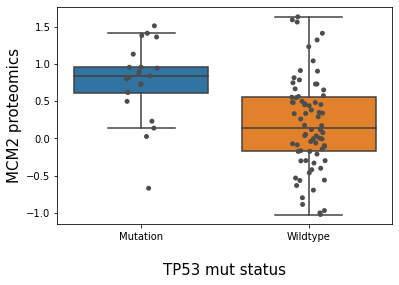

In [ ]:
import seaborn as sns

plot = sns.boxplot(data = mut_and_proteomics, x = 'Simple_mut_status', y = 'MCM2_proteomics', showfliers = False)
plot = sns.stripplot(data = mut_and_proteomics, x = 'Simple_mut_status', y = 'MCM2_proteomics', jitter = True, dodge = True, color = '.3')
plot.set_xlabel("\nTP53 mut status", fontsize=15)
plot.set_ylabel("MCM2 proteomics", fontsize=15)